 # <center> **DETECCIÓN/CLASIFICACIÓN DE CONTENEDORES DE BASURA MEDIANTE IMÁGENES TOMADAS DE GOOGLE MAPS USANDO REDES NEURONALES** </center>


INTEGRANTES:

Albarracin Juan Ricardo

Rengifo Christian Alejandro 


## Tratamiento del dataset:
Link del dataset: https://www.kaggle.com/rodrigolaguna/clean-dirty-containers-in-montevideo

In [216]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/PROYECTO IA2')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/PROYECTO IA2


In [217]:
!pwd

/content/drive/MyDrive/PROYECTO IA2


In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from sklearn.datasets import make_regression
import os
import cv2
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [219]:
path_classes = 'Data/clean-dirty-garbage-containers/'
classes_names = os.listdir(path_classes)
classes_names.sort()
classes_names = classes_names[0:]

print(classes_names)

list_imgs = []
dic_imgs= {}
for i, name_class in enumerate(classes_names):
    list_imgs = list_imgs +[name_class+ "/"+ s for s in (os.listdir(path_classes + classes_names[i]))] 
    dic_imgs[classes_names[i]]=np.array(os.listdir(path_classes + classes_names[i])) #diccionario que tiene como keys: (clean, dirty) y como values las respectivas imagenes correspondientes a las keys
array_imgs = np.array(list_imgs) #array con los nombres de las imagenes con formato 'clase/nombreimagen'
print(dic_imgs)
print(array_imgs)
print(array_imgs.shape)

['clean', 'dirty']
{'clean': array(['0045.jpg', '0086.jpg', '0239.jpg', ..., '0105.jpg', '0123.jpg',
       '0062.jpg'], dtype='<U8'), 'dirty': array(['0377.jpg', '0302.jpg', '0287.jpg', ..., '0478.jpg', '0257.jpg',
       '0247.jpg'], dtype='<U8')}
['clean/0045.jpg' 'clean/0086.jpg' 'clean/0239.jpg' ... 'dirty/0478.jpg'
 'dirty/0257.jpg' 'dirty/0247.jpg']
(3004,)


In [220]:
dic_imgs.keys()

dict_keys(['clean', 'dirty'])

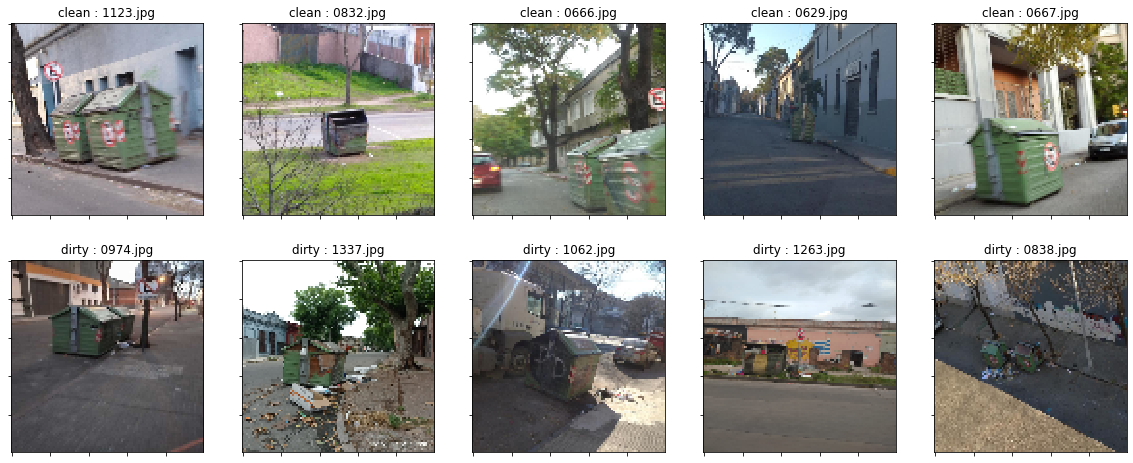

In [221]:
num_samples=5
cont = 1
fig = plt.figure(figsize=(20,8))
for classes in ['clean','dirty']:
    perm = np.random.permutation(range(dic_imgs[classes].shape[0]))[0:num_samples]
    random_images_names = dic_imgs[classes][perm]
    for im_name in random_images_names:
        ax=fig.add_subplot(len(classes_names),num_samples,cont)
        path_image = path_classes+classes+'/'+im_name 
        img = cv2.cvtColor(cv2.imread(path_image), cv2.COLOR_BGR2RGB)
        img= cv2.resize(img, (100,100))
        plt.imshow(img, interpolation="nearest")
        ax.set_title((classes+" : " + im_name))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        cont +=1 

In [222]:
X =[]
y =[]
resize_value =100

#etiquetar las clases 
for i, classes in enumerate(['clean','dirty']):
    print((i), "clase: ", classes, " y_value:",  (i), " total: ", len(dic_imgs[classes]))
    
    for im_name in dic_imgs[classes]:
        path_image = path_classes+classes+'/'+im_name        
        img = cv2.resize(cv2.imread(path_image,3), (100, 100))
        #flatt_img = img.reshape(resize_value*resize_value)
        X.append(img)
        #print len(X)
        y.append(i)



0 clase:  clean  y_value: 0  total:  1646
1 clase:  dirty  y_value: 1  total:  1358


### Data Augmentation

In [223]:
def DataAugmentation(X):
  datagen = ImageDataGenerator(featurewise_center          = False,  # pone la media de los rasgos a cero el conjunto de datos 
                              samplewise_center            = False,  # pone cada dato a media cero
                              featurewise_std_normalization= False,  # divide cada razgo entre su desv estandard
                              samplewise_std_normalization = False,  # divide cada dato entre su desv estandard
                              zoom_range=0.1,
                              rotation_range               = 10,      # rota aleatoriamente la imagens estos grados (0 a +-180)
                              width_shift_range            = 0.1,    # recorre la imagen horizontalmente una razon alaatoria [0, r]
                              height_shift_range           = 0.1,    # recorre la imagen verticalmente una razon alaatoria [0, r]
                              horizontal_flip              = True,   # refleja aleatoriamente la imagen en forma horizontal
                              vertical_flip                = False)  # refleja aleatoriamente la imagen en forma vertical)
  datagen.fit(X)
  return datagen


In [224]:
X = np.r_[X]        
y = np.r_[y]
classes_names = {0:'clean', 1:'dirty'}

In [225]:
from sklearn.model_selection import train_test_split
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size, train_size=0.8)
print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2403, 100, 100, 3) (2403,) (601, 100, 100, 3) (601,)


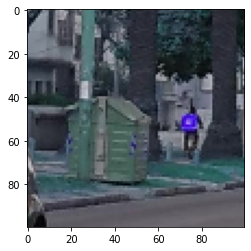

In [226]:
plt.imshow(X_train[1].reshape(100,100,3))

In [227]:
print(y_test.shape)
print(y_train.shape)

(601,)
(2403,)


In [228]:
x_train = X_train.reshape([-1, 100, 100, 3]) #AGREGAMOS -1 PARA LOS INDICES DE LAS IMAGENES
x_test = X_test.reshape([-1, 100, 100, 3])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255 #NORMALIZAMOS
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (2403, 100, 100, 3)
Number of images in x_train 2403
Number of images in x_test 601


In [229]:
datagen =DataAugmentation(x_train)


In [230]:
from keras.utils import np_utils
n_classes = 2
print("Shape antes del OneHotEncoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train,n_classes)
Y_test = np_utils.to_categorical(y_test,n_classes)
print("Shape después del OneHotEncoding: ", Y_train.shape)

Shape antes del OneHotEncoding:  (2403,)
Shape después del OneHotEncoding:  (2403, 2)


In [231]:
data_train = datagen.flow(x_train, Y_train, batch_size=64)


## CNN MODEL

In [232]:
model =  tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_uniform', activation='relu', input_shape=[100,100,3]))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 98, 98, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 49, 49, 64)        18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 49, 49, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 64)       

In [233]:
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt,  loss='categorical_crossentropy', metrics=['accuracy'])

In [234]:
history = model.fit(data_train, epochs=20, verbose=1,validation_data=(x_test,Y_test))

Epoch 1/20
38/38 [==============================] - 6s 155ms/step - loss: 0.7177 - accuracy: 0.5285 - val_loss: 0.6727 - val_accuracy: 0.6073
Epoch 2/20
38/38 [==============================] - 6s 148ms/step - loss: 0.6773 - accuracy: 0.5909 - val_loss: 0.6771 - val_accuracy: 0.5574
Epoch 3/20
38/38 [==============================] - 6s 147ms/step - loss: 0.6710 - accuracy: 0.6038 - val_loss: 0.6596 - val_accuracy: 0.6489
Epoch 4/20
38/38 [==============================] - 6s 147ms/step - loss: 0.6587 - accuracy: 0.6237 - val_loss: 0.6685 - val_accuracy: 0.5824
Epoch 5/20
38/38 [==============================] - 6s 149ms/step - loss: 0.6813 - accuracy: 0.5793 - val_loss: 0.6502 - val_accuracy: 0.6589
Epoch 6/20
38/38 [==============================] - 6s 148ms/step - loss: 0.6565 - accuracy: 0.6166 - val_loss: 0.6455 - val_accuracy: 0.6339
Epoch 7/20
38/38 [==============================] - 6s 147ms/step - loss: 0.6485 - accuracy: 0.6352 - val_loss: 0.6312 - val_accuracy: 0.6539
Epoch 

In [235]:
# Guardar el modelo
model.save('/content/drive/My Drive/PROYECTO IA2/Data/Models/CNN_v1.h5')

In [236]:
model= tf.keras.models.load_model('/content/drive/My Drive/PROYECTO IA2/Data/Models/CNN_v1.h5')

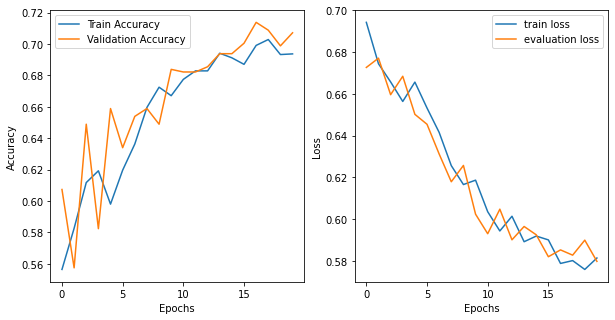

In [237]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

In [238]:
test_loss, test_acc = model.evaluate(x_test, Y_test, verbose=0)

print('Test accuracy:', test_acc)

Test accuracy: 0.7071547508239746


## TRANSFER LEARNING

### MobileNet V2

In [239]:
model_A =  tf.keras.applications.MobileNetV2(input_shape=x_train[0].shape, weights='imagenet', include_top=False)
model_A.trainable = False
model_A.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 50, 50, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 50, 50, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 50, 50, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [240]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
flatten_layer = tf.keras.layers.Flatten()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # To mobilenet cnns

In [241]:
model_B_on_A = tf.keras.Sequential([
  model_A,
  global_average_layer,
  prediction_layer
])

In [242]:
model_B_on_A.summary()
print("number of layers to train: ", len(model_B_on_A.trainable_variables))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
number of layers to train:  2


In [243]:
learning_rate= 0.001
opt = tf.keras.optimizers.SGD(lr=learning_rate, momentum=0.9)
model_B_on_A.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

history = model_B_on_A.fit(data_train, epochs=20, validation_data=(x_test, Y_test))

Epoch 1/20
38/38 [==============================] - 8s 164ms/step - loss: 0.8357 - accuracy: 0.5571 - val_loss: 0.7219 - val_accuracy: 0.6789
Epoch 2/20
38/38 [==============================] - 5s 142ms/step - loss: 0.5954 - accuracy: 0.7127 - val_loss: 0.6150 - val_accuracy: 0.7038
Epoch 3/20
38/38 [==============================] - 5s 143ms/step - loss: 0.5617 - accuracy: 0.7304 - val_loss: 0.5796 - val_accuracy: 0.7022
Epoch 4/20
38/38 [==============================] - 5s 142ms/step - loss: 0.5499 - accuracy: 0.7231 - val_loss: 0.5684 - val_accuracy: 0.7421
Epoch 5/20
38/38 [==============================] - 5s 143ms/step - loss: 0.5338 - accuracy: 0.7539 - val_loss: 0.5534 - val_accuracy: 0.7354
Epoch 6/20
38/38 [==============================] - 5s 143ms/step - loss: 0.5105 - accuracy: 0.7502 - val_loss: 0.5451 - val_accuracy: 0.7488
Epoch 7/20
38/38 [==============================] - 5s 143ms/step - loss: 0.5303 - accuracy: 0.7349 - val_loss: 0.5689 - val_accuracy: 0.7438
Epoch 

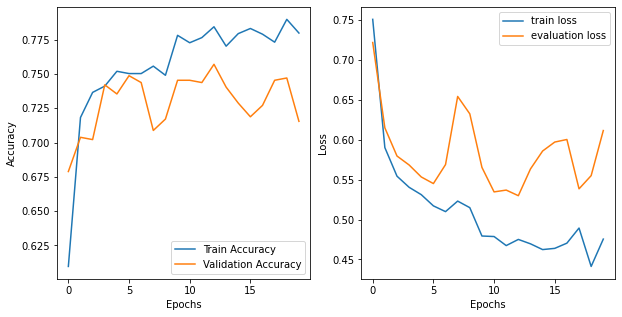

In [244]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

### MobileNet V2 with Fine Tunning

Descongelando y entrenando las primeras 100 capas

In [245]:
model_A.trainable = True
print("Total layers of Mobilenet: ", len(model_A.layers))
for layer in model_A.layers[:100]:
  layer.trainable =  False
print("Total layers of Mobilenet: ", len(model_A.layers))

Total layers of Mobilenet:  154
Total layers of Mobilenet:  154


In [246]:
model_B_on_A.summary()
len(model_B_on_A.trainable_variables)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 1,864,002
Non-trainable params: 396,544
_________________________________________________________________


56

In [247]:
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model_B_on_A.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

history = model_B_on_A.fit(data_train, epochs=20,verbose=1,validation_data=(x_test, Y_test))

Epoch 1/20
38/38 [==============================] - 9s 171ms/step - loss: 0.5970 - accuracy: 0.6976 - val_loss: 1.1490 - val_accuracy: 0.6572
Epoch 2/20
38/38 [==============================] - 6s 150ms/step - loss: 0.4657 - accuracy: 0.7807 - val_loss: 0.8765 - val_accuracy: 0.6988
Epoch 3/20
38/38 [==============================] - 6s 149ms/step - loss: 0.4169 - accuracy: 0.8107 - val_loss: 0.7451 - val_accuracy: 0.7338
Epoch 4/20
38/38 [==============================] - 6s 150ms/step - loss: 0.3863 - accuracy: 0.8231 - val_loss: 0.7997 - val_accuracy: 0.7304
Epoch 5/20
38/38 [==============================] - 6s 148ms/step - loss: 0.3196 - accuracy: 0.8620 - val_loss: 0.7876 - val_accuracy: 0.7404
Epoch 6/20
38/38 [==============================] - 6s 147ms/step - loss: 0.3070 - accuracy: 0.8623 - val_loss: 0.9030 - val_accuracy: 0.7354
Epoch 7/20
38/38 [==============================] - 6s 149ms/step - loss: 0.2862 - accuracy: 0.8702 - val_loss: 0.9185 - val_accuracy: 0.7288
Epoch 

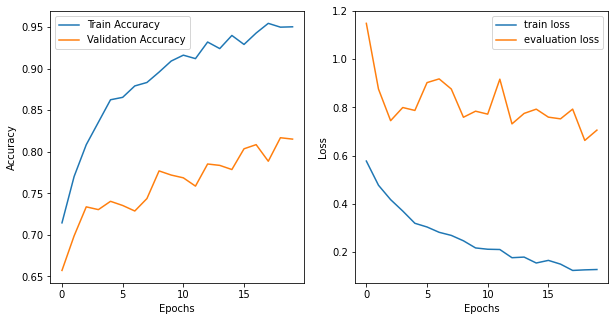

In [248]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

### Xception

In [249]:
model_X =  tf.keras.applications.Xception(input_shape=x_train[0].shape, weights='imagenet', include_top=False)
model_X.trainable = False
model_X.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [250]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
flatten_layer = tf.keras.layers.Flatten()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # To mobilenet cnns

In [251]:
model_B_on_X = tf.keras.Sequential([
  model_X,
  global_average_layer,
  prediction_layer
])

In [252]:
model_B_on_X.summary()
print("number of layers to train: ", len(model_B_on_A.trainable_variables))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
_________________________________________________________________
number of layers to train:  56


In [253]:
learning_rate= 0.001
opt = tf.keras.optimizers.SGD(lr=learning_rate, momentum=0.9)
model_B_on_X.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

history = model_B_on_X.fit(data_train, epochs=20, validation_data=(x_test, Y_test))

Epoch 1/20
38/38 [==============================] - 9s 179ms/step - loss: 0.7433 - accuracy: 0.4879 - val_loss: 0.6299 - val_accuracy: 0.6473
Epoch 2/20
38/38 [==============================] - 6s 158ms/step - loss: 0.6252 - accuracy: 0.6591 - val_loss: 0.6010 - val_accuracy: 0.6789
Epoch 3/20
38/38 [==============================] - 6s 158ms/step - loss: 0.5829 - accuracy: 0.6996 - val_loss: 0.5748 - val_accuracy: 0.7088
Epoch 4/20
38/38 [==============================] - 6s 157ms/step - loss: 0.5453 - accuracy: 0.7240 - val_loss: 0.5585 - val_accuracy: 0.7105
Epoch 5/20
38/38 [==============================] - 6s 158ms/step - loss: 0.5551 - accuracy: 0.7087 - val_loss: 0.5508 - val_accuracy: 0.7388
Epoch 6/20
38/38 [==============================] - 6s 160ms/step - loss: 0.5443 - accuracy: 0.7233 - val_loss: 0.5425 - val_accuracy: 0.7271
Epoch 7/20
38/38 [==============================] - 6s 160ms/step - loss: 0.5210 - accuracy: 0.7364 - val_loss: 0.5378 - val_accuracy: 0.7321
Epoch 

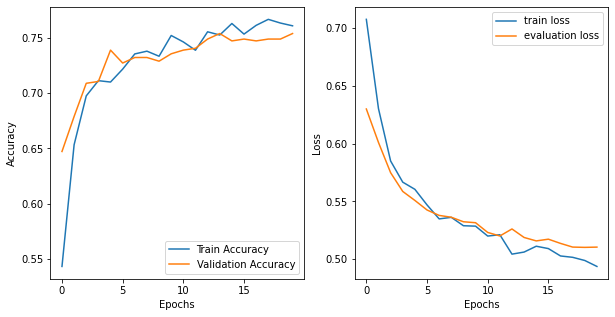

In [254]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

### Xception with Fine Tunning

Descongelando y entrenando las primeras 100 capas

In [255]:
model_X.trainable = True
print("Total layers of Mobilenet: ", len(model_X.layers))
for layer in model_X.layers[:100]:
  layer.trainable =  False
print("Total layers of Mobilenet: ", len(model_X.layers))

Total layers of Mobilenet:  132
Total layers of Mobilenet:  132


In [256]:
model_B_on_X.summary()
len(model_B_on_X.trainable_variables)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 9,482,442
Non-trainable params: 11,383,136
_________________________________________________________________


41

In [257]:
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model_B_on_X.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_B_on_X.fit(data_train, epochs=20,verbose=1,validation_data=(x_test, Y_test))

Epoch 1/20
38/38 [==============================] - 10s 188ms/step - loss: 0.6212 - accuracy: 0.6741 - val_loss: 0.5143 - val_accuracy: 0.7454
Epoch 2/20
38/38 [==============================] - 6s 169ms/step - loss: 0.5971 - accuracy: 0.7021 - val_loss: 0.5113 - val_accuracy: 0.7521
Epoch 3/20
38/38 [==============================] - 6s 169ms/step - loss: 0.5743 - accuracy: 0.7381 - val_loss: 0.5053 - val_accuracy: 0.7454
Epoch 4/20
38/38 [==============================] - 6s 169ms/step - loss: 0.5677 - accuracy: 0.7371 - val_loss: 0.4955 - val_accuracy: 0.7521
Epoch 5/20
38/38 [==============================] - 6s 168ms/step - loss: 0.5369 - accuracy: 0.7670 - val_loss: 0.4884 - val_accuracy: 0.7621
Epoch 6/20
38/38 [==============================] - 6s 170ms/step - loss: 0.5181 - accuracy: 0.7714 - val_loss: 0.4889 - val_accuracy: 0.7454
Epoch 7/20
38/38 [==============================] - 7s 171ms/step - loss: 0.5177 - accuracy: 0.7646 - val_loss: 0.4771 - val_accuracy: 0.7671
Epoch

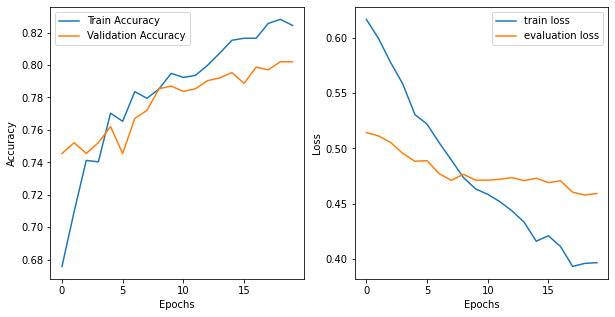

In [258]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

## PRUEBAS Y RESULTADOS

### Confusion Matrix

In [259]:

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\ntest accuracy={:0.4f}'.format(accuracy, misclass))
    plt.show()

#### Model CNN

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(601,)


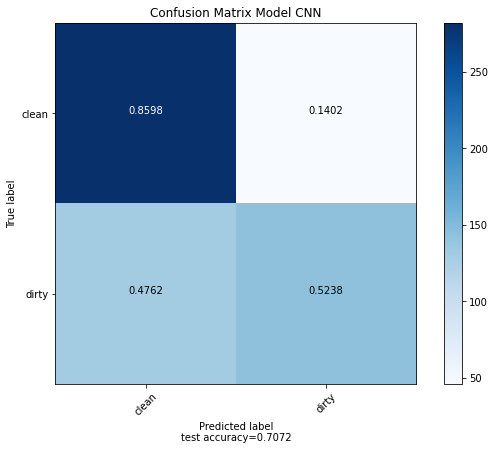

In [260]:
from sklearn.metrics import confusion_matrix

predictions = model.predict_classes(x_test)
print(predictions.shape)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, target_names=['clean', 'dirty'], title = "Confusion Matrix Model CNN")

#### Model MobileNetV2

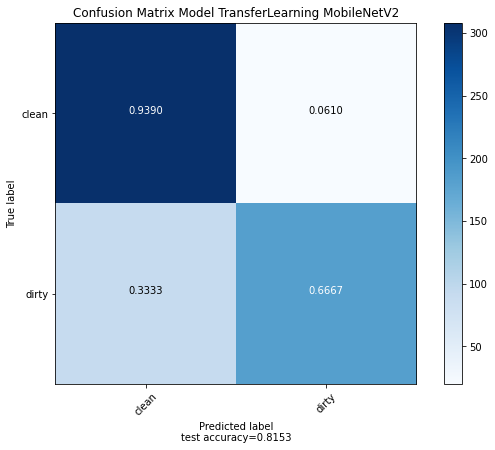

In [261]:
from sklearn.metrics import confusion_matrix


predictions = model_B_on_A.predict(x_test)

pclasses = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, pclasses)
plot_confusion_matrix(cm, target_names=['clean', 'dirty'], title = "Confusion Matrix Model TransferLearning MobileNetV2")

#### Model Xception

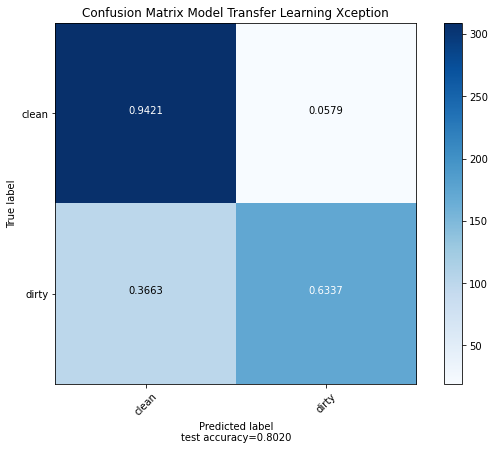

In [262]:
predictions = model_B_on_X.predict(x_test)

pclasses = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, pclasses)
plot_confusion_matrix(cm, target_names=['clean', 'dirty'], title = "Confusion Matrix Model Transfer Learning Xception")

### Probando con New Dataset

In [263]:
path_classes = 'Data/colombianData/'
classes_names = os.listdir(path_classes)
classes_names.sort()
classes_names = classes_names[0:]

print(classes_names)

list_imgs = []
dic_imgs= {}
for i, name_class in enumerate(classes_names):
    list_imgs = list_imgs +[name_class+ "/"+ s for s in (os.listdir(path_classes + classes_names[i]))] 
    dic_imgs[classes_names[i]]=np.array(os.listdir(path_classes + classes_names[i])) #diccionario que tiene como keys: (clean, dirty) y como values las respectivas imagenes correspondientes a las keys
array_imgs = np.array(list_imgs) #array con los nombres de las imagenes con formato 'clase/nombreimagen'
print(dic_imgs)
print(array_imgs.shape)

['clean', 'dirty']
{'clean': array(['01.jpg', '02.JPG', '03.JPG', '04.JPG', '05.JPG', '06.JPG',
       '07.JPG', '08.JPG', '09.JPG', '10.JPG', '11.JPG', '12.JPG',
       '13.JPG', '14.JPG', '15.JPG', '16.JPG', '17.JPG', '18.JPG',
       '19.JPG', '20.JPG', '21.JPG', '22.JPG', '23.JPG', '24.JPG',
       '25.JPG', '26.JPG', '27.JPG', '28.JPG', '29.JPG', '30.JPG',
       '31.JPG', '32.JPG', '33.JPG', '34.JPG', '35.JPG', '36.JPG',
       '37.JPG', '38.JPG', '39.JPG', '40.JPG', '41.JPG', '42.JPG',
       '43.JPG', '44.JPG', '45.JPG', '46.JPG', '47.JPG', '48.JPG',
       '49.JPG', '50.JPG', '053.jpg', '054.jpg', '055.jpg', '056.jpg',
       '057.jpg', '058.jpg', '059.jpg', '060.jpg', '061.jpg', '062.jpg',
       '063.jpg', '064.jpg', '065.jpg', '066.png', '066.jpg', '067.jpg',
       '068.jpg', '069.jpg', '070.jpg', '071.jpg', '071.png', '072.jpg',
       '073.jpg', '074.jpg', '075.jpg', '076.jpg', '077.jpg', '078.jpg',
       '079.jpg', '080.jpg', '081.jpg', '082.jpg', '083.jpg', '084.jpg',

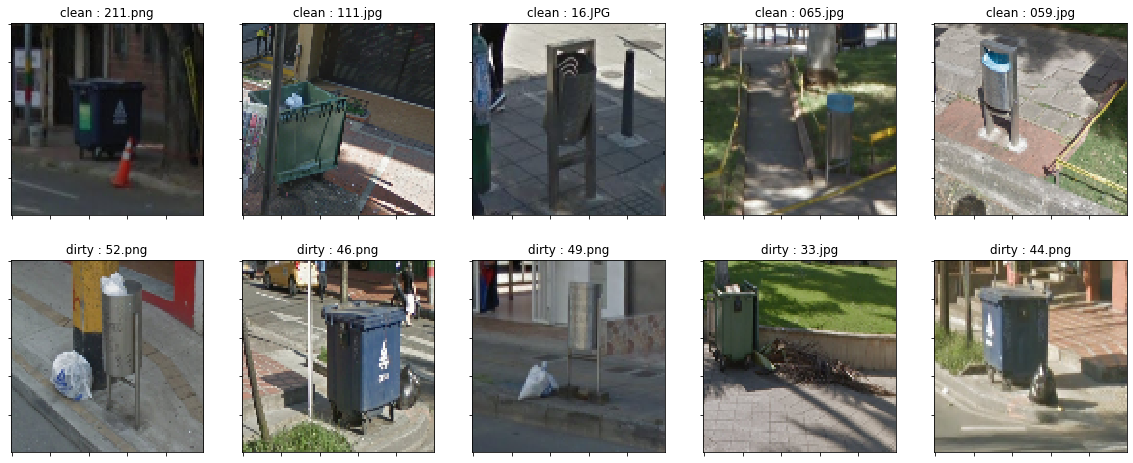

In [264]:
num_samples=5
cont = 1
fig = plt.figure(figsize=(20,8))
for classes in ['clean','dirty']:
    perm = np.random.permutation(range(dic_imgs[classes].shape[0]))[0:num_samples]
    random_images_names = dic_imgs[classes][perm]
    for im_name in random_images_names:
        ax=fig.add_subplot(len(classes_names),num_samples,cont)
        path_image = path_classes+classes+'/'+im_name 
        img = cv2.cvtColor(cv2.imread(path_image), cv2.COLOR_BGR2RGB)
        img= cv2.resize(img, (100,100))
        plt.imshow(img, interpolation="nearest")
        ax.set_title((classes+" : " + im_name))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        cont +=1 

In [265]:
Xclean =[]
yclean =[]
resize_value =100

#etiquetar las clases 
for i, classes in enumerate(['clean']):
    print((i), "clase: ", classes, " y_value:",  (i), " total: ", len(dic_imgs[classes]))
    
    for im_name in dic_imgs[classes]:
        path_image = path_classes+classes+'/'+im_name        
        img = cv2.resize(cv2.imread(path_image,3), (100, 100))
        #flatt_img = img.reshape(resize_value*resize_value)
        Xclean.append(img)
        #print len(X)
        yclean.append(i)

0 clase:  clean  y_value: 0  total:  214


In [266]:
Xdirty =[]
ydirty =[]
resize_value =100

#etiquetar las clases 
for i, classes in enumerate(['dirty']):
    print((i), "clase: ", classes, " y_value:",  (i+1), " total: ", len(dic_imgs[classes]))
    
    for im_name in dic_imgs[classes]:
        path_image = path_classes+classes+'/'+im_name        
        img = cv2.resize(cv2.imread(path_image,3), (100, 100))
        #flatt_img = img.reshape(resize_value*resize_value)
        Xdirty.append(img)
        #print len(X)
        ydirty.append(i+1)

0 clase:  dirty  y_value: 1  total:  77


In [267]:
def DataAugmentation2(X):
  datagen = ImageDataGenerator(featurewise_center          = False,  # pone la media de los rasgos a cero el conjunto de datos 
                              samplewise_center            = False,  # pone cada dato a media cero
                              featurewise_std_normalization= False,  # divide cada razgo entre su desv estandard
                              samplewise_std_normalization = False,  # divide cada dato entre su desv estandard
                              zoom_range=0.1,
                              rotation_range               = 5,      # rota aleatoriamente la imagens estos grados (0 a +-180)
                              #width_shift_range            = 0.2,    # recorre la imagen horizontalmente una razon alaatoria [0, r]
                              #height_shift_range           = 0.2,    # recorre la imagen verticalmente una razon alaatoria [0, r]
                              horizontal_flip              = True,   # refleja aleatoriamente la imagen en forma horizontal
                              vertical_flip                = False, # refleja aleatoriamente la imagen en forma vertical)
                              brightness_range             = [1.0, 1.2])  
  datagen.fit(X)
  return datagen

In [268]:
Xclean = np.r_[Xclean]        
Xdirty = np.r_[Xdirty]
Xclean = Xclean.astype('float32')
Xdirty = Xdirty.astype('float32')
Xclean = Xclean.reshape([-1, 100, 100, 3]) #AGREGAMOS -1 PARA LOS INDICES DE LAS IMAGENES
Xdirty= Xdirty.reshape([-1, 100, 100, 3])

In [269]:
datagen_clean =DataAugmentation2(Xclean)
datagen_dirty =DataAugmentation2(Xdirty)

In [270]:
len(Xclean)*3

642

In [271]:
!pwd

/content/drive/My Drive/PROYECTO IA2


mkdir: cannot create directory ‘Data/data_col_aug/clean’: File exists


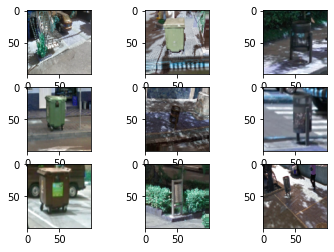

In [272]:
!mkdir Data/data_col_aug/clean

for X_batchclean in datagen_clean.flow(Xclean, batch_size=len(Xclean), save_to_dir='Data/data_col_aug/clean', save_prefix='clean', save_format='jpg'):
  for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_batchclean[i].reshape(100, 100, 3).astype('uint8'), cmap=plt.cm.binary);
  plt.show()
  break

mkdir: cannot create directory ‘Data/data_col_aug/dirty’: File exists


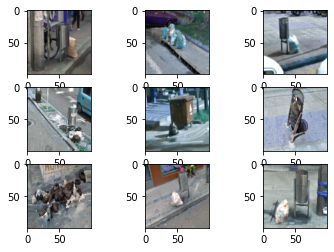

In [273]:
!mkdir Data/data_col_aug/dirty

for X_batchdirty in datagen_clean.flow(Xdirty, batch_size=len(Xclean), save_to_dir='Data/data_col_aug/dirty', save_prefix='dirty', save_format='jpg'):
  for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_batchdirty[i].reshape(100, 100, 3).astype('uint8'), cmap=plt.cm.binary);
  plt.show()
  break

In [274]:
Xnew =[]
ynew =[]
resize_value =100
path_classes = 'Data/colombianData/'

classes_names = os.listdir(path_classes)
classes_names.sort()
classes_names = classes_names[0:]



list_imgs = []
dic_imgs= {}
for i, name_class in enumerate(classes_names):
    list_imgs = list_imgs +[name_class+ "/"+ s for s in (os.listdir(path_classes + classes_names[i]))] 
    dic_imgs[classes_names[i]]=np.array(os.listdir(path_classes + classes_names[i])) #diccionario que tiene como keys: (clean, dirty) y como values las respectivas imagenes correspondientes a las keys
array_imgs = np.array(list_imgs) #array con los nombres de las imagenes con formato 'clase/nombreimagen'

#etiquetar las clases 
for i, classes in enumerate(['clean', 'dirty']):
    print((i), "clase: ", classes, " y_value:",  (i), " total: ", len(dic_imgs[classes]))
    
    for im_name in dic_imgs[classes]:
        path_image = path_classes+classes+'/'+im_name        
        img = cv2.resize(cv2.imread(path_image,3), (100, 100))
        Xnew.append(img)
        #print len(X)
        ynew.append(i)
Xnew = np.r_[Xnew]
ynew = np.r_[ynew]

0 clase:  clean  y_value: 0  total:  214
1 clase:  dirty  y_value: 1  total:  77


#### Model CNN

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(291,)


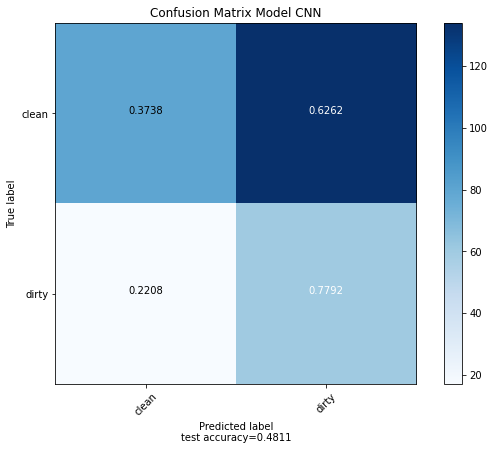

In [275]:
from sklearn.metrics import confusion_matrix

predictions = model.predict_classes(Xnew)
print(predictions.shape)
cm = confusion_matrix(ynew, predictions)
plot_confusion_matrix(cm, target_names=['clean', 'dirty'], title = "Confusion Matrix Model CNN")

#### Model MobileNetV2

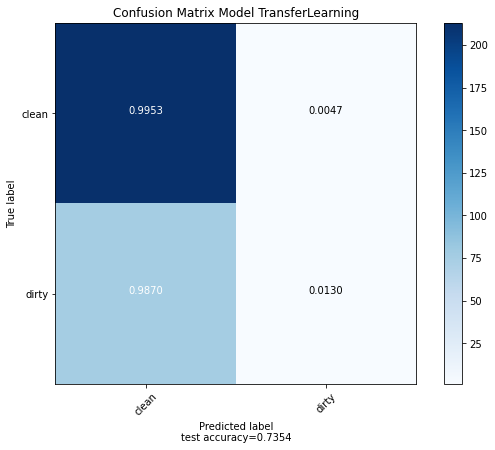

In [276]:
from sklearn.metrics import confusion_matrix


predictions = model_B_on_A.predict(Xnew)

pclasses = np.argmax(predictions, axis=1)

cm = confusion_matrix(ynew, pclasses)
plot_confusion_matrix(cm, target_names=['clean', 'dirty'], title = "Confusion Matrix Model TransferLearning")

#### Model Xception

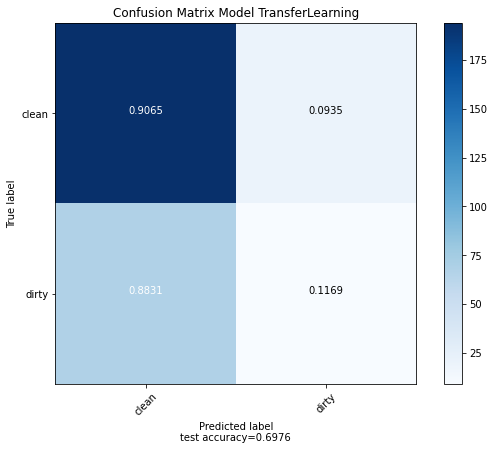

In [277]:
predictions = model_B_on_X.predict(Xnew)

pclasses = np.argmax(predictions, axis=1)

cm = confusion_matrix(ynew, pclasses)
plot_confusion_matrix(cm, target_names=['clean', 'dirty'], title = "Confusion Matrix Model TransferLearning")

### Pruebas al modelo CNN


Prueba con imagen del x_test

The class predicted is:  dirty


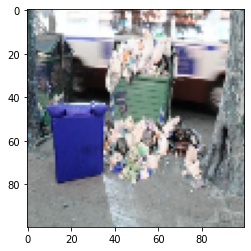

In [278]:
img_rows, img_cols =100, 100
image_index = 88
plt.imshow(x_test[image_index].reshape(100, 100,3),cmap='Greys')
pred = model.predict(x_test[image_index].reshape(1, img_rows, img_cols, 3))
print ("The class predicted is: ", classes_names[pred.argmax()])

Prueba con imagen externa al dataset 

<class 'PIL.Image.Image'>


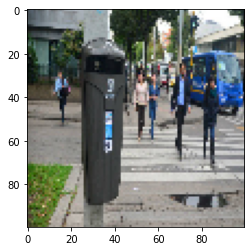

In [279]:
filename = './Data/test_imgs/Climpio2.jpg'
im = tf.keras.preprocessing.image.load_img(filename, target_size=(100, 100))
print ( type(im))
plt.imshow(im);

In [280]:
ima = tf.keras.preprocessing.image.img_to_array(im)
ima = np.expand_dims(ima, axis=0)
print (ima.shape)

(1, 100, 100, 3)


In [281]:
prediction = model.predict(ima)
print(prediction)
print ("valor predicho:",  np.argmax(prediction[0]), " clase: ", classes_names[np.argmax(prediction[0])])

[[0. 1.]]
valor predicho: 1  clase:  dirty


<class 'PIL.Image.Image'>


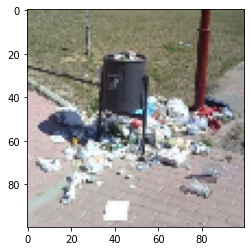

In [282]:
filename = './Data/test_imgs/Csucio2.jpg'
im = tf.keras.preprocessing.image.load_img(filename, target_size=(100, 100))
print ( type(im))
plt.imshow(im);

In [283]:
ima = tf.keras.preprocessing.image.img_to_array(im)
ima = np.expand_dims(ima, axis=0)
print (ima.shape)

(1, 100, 100, 3)


In [284]:
prediction = model.predict(ima)
print(prediction)
print ("valor predicho:",  np.argmax(prediction[0]), " clase: ", classes_names[np.argmax(prediction[0])])

[[0. 1.]]
valor predicho: 1  clase:  dirty


<class 'PIL.Image.Image'>


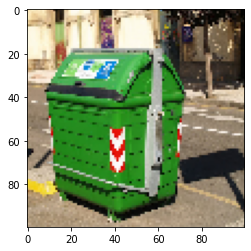

In [285]:
filename = './Data/test_imgs/Climpio1.jpg'
im = tf.keras.preprocessing.image.load_img(filename, target_size=(100, 100))
print ( type(im))
plt.imshow(im);

In [286]:
ima = tf.keras.preprocessing.image.img_to_array(im)
ima = np.expand_dims(ima, axis=0)
print (ima.shape)

(1, 100, 100, 3)


In [287]:
prediction = model.predict(ima)
print(prediction)
print ("valor predicho:",  np.argmax(prediction[0]), " clase: ", classes_names[np.argmax(prediction[0])])

[[0. 1.]]
valor predicho: 1  clase:  dirty


### Pruebas al modelo de Transfer Learning MobileNet


Prueba con imagen del x_test

The class predicted is:  dirty


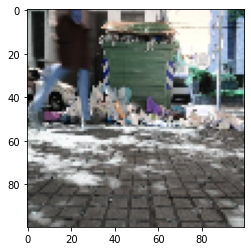

In [288]:
img_rows, img_cols =100, 100
image_index = 83
plt.imshow(x_test[image_index].reshape(100, 100,3),cmap='Greys')
pred = model_B_on_A.predict(x_test[image_index].reshape(1, img_rows, img_cols, 3)) #Modelo de transfer learning con MobileNet
print ("The class predicted is: ", classes_names[pred.argmax()])

Prueba con imagen externa al dataset 

<class 'PIL.Image.Image'>


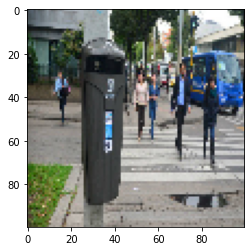

In [289]:
filename = './Data/test_imgs/Climpio2.jpg'
im = tf.keras.preprocessing.image.load_img(filename, target_size=(100, 100))
print ( type(im))
plt.imshow(im);

In [290]:
ima = tf.keras.preprocessing.image.img_to_array(im)
ima = np.expand_dims(ima, axis=0)
print (ima.shape)

(1, 100, 100, 3)


In [291]:
prediction = model_B_on_A.predict(ima)
print(prediction)
print ("valor predicho:",  np.argmax(prediction[0]), " clase: ", classes_names[np.argmax(prediction[0])])

[[0.99117434 0.00882559]]
valor predicho: 0  clase:  clean


<class 'PIL.Image.Image'>


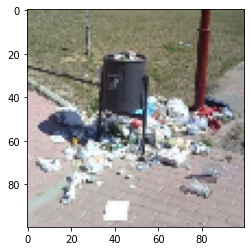

In [292]:
filename = './Data/test_imgs/Csucio2.jpg'
im = tf.keras.preprocessing.image.load_img(filename, target_size=(100, 100))
print ( type(im))
plt.imshow(im);

In [293]:
ima = tf.keras.preprocessing.image.img_to_array(im)
ima = np.expand_dims(ima, axis=0)
print (ima.shape)

(1, 100, 100, 3)


In [294]:
prediction = model_B_on_A.predict(ima)
print(prediction)
print ("valor predicho:",  np.argmax(prediction[0]), " clase: ", classes_names[np.argmax(prediction[0])])

[[0.78522724 0.21477269]]
valor predicho: 0  clase:  clean


<class 'PIL.Image.Image'>


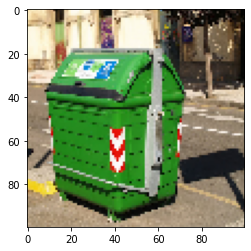

In [295]:
filename = './Data/test_imgs/Climpio1.jpg'
im = tf.keras.preprocessing.image.load_img(filename, target_size=(100, 100))
print ( type(im))
plt.imshow(im);

In [296]:
ima = tf.keras.preprocessing.image.img_to_array(im)
ima = np.expand_dims(ima, axis=0)
print (ima.shape)

(1, 100, 100, 3)


In [297]:
prediction = model_B_on_A.predict(ima)
print(prediction)
print ("valor predicho:",  np.argmax(prediction[0]), " clase: ", classes_names[np.argmax(prediction[0])])

[[0.97575116 0.02424884]]
valor predicho: 0  clase:  clean


### Pruebas al modelo de Transfer Learning Xception


Prueba con imagen del x_test

The class predicted is:  dirty


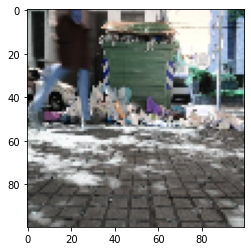

In [298]:
img_rows, img_cols =100, 100
image_index = 83
plt.imshow(x_test[image_index].reshape(100, 100,3),cmap='Greys')
pred = model_B_on_X.predict(x_test[image_index].reshape(1, img_rows, img_cols, 3)) #Modelo de transfer learning con MobileNet
print ("The class predicted is: ", classes_names[pred.argmax()])

Prueba con imagen externa al dataset 

<class 'PIL.Image.Image'>


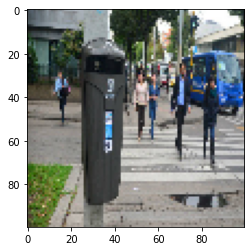

In [299]:
filename = './Data/test_imgs/Climpio2.jpg'
im = tf.keras.preprocessing.image.load_img(filename, target_size=(100, 100))
print ( type(im))
plt.imshow(im);

In [300]:
ima = tf.keras.preprocessing.image.img_to_array(im)
ima = np.expand_dims(ima, axis=0)
print (ima.shape)

(1, 100, 100, 3)


In [301]:
prediction = model_B_on_X.predict(ima)
print(prediction)
print ("valor predicho:",  np.argmax(prediction[0]), " clase: ", classes_names[np.argmax(prediction[0])])

[[0.9150887 0.0849113]]
valor predicho: 0  clase:  clean


<class 'PIL.Image.Image'>


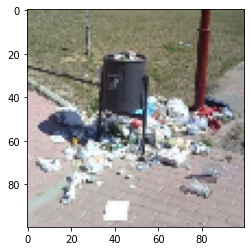

In [302]:
filename = './Data/test_imgs/Csucio2.jpg'
im = tf.keras.preprocessing.image.load_img(filename, target_size=(100, 100))
print ( type(im))
plt.imshow(im);

In [303]:
ima = tf.keras.preprocessing.image.img_to_array(im)
ima = np.expand_dims(ima, axis=0)
print (ima.shape)

(1, 100, 100, 3)


In [304]:
prediction = model_B_on_X.predict(ima)
print(prediction)
print ("valor predicho:",  np.argmax(prediction[0]), " clase: ", classes_names[np.argmax(prediction[0])])

[[1.0000000e+00 3.5380106e-16]]
valor predicho: 0  clase:  clean


<class 'PIL.Image.Image'>


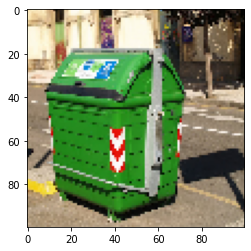

In [305]:
filename = './Data/test_imgs/Climpio1.jpg'
im = tf.keras.preprocessing.image.load_img(filename, target_size=(100, 100))
print ( type(im))
plt.imshow(im);

In [306]:
ima = tf.keras.preprocessing.image.img_to_array(im)
ima = np.expand_dims(ima, axis=0)
print (ima.shape)

(1, 100, 100, 3)


In [307]:
prediction = model_B_on_X.predict(ima)
print(prediction)
print ("valor predicho:",  np.argmax(prediction[0]), " clase: ", classes_names[np.argmax(prediction[0])])

[[1.000000e+00 3.823697e-21]]
valor predicho: 0  clase:  clean


# Aumentando el dataset de Uruguay con nuestro dataset

In [308]:
Xnew =[]
ynew =[]
resize_value =100
path_classes = 'Data/colombianData/'

classes_names = os.listdir(path_classes)
classes_names.sort()
classes_names = classes_names[0:]



list_imgs = []
dic_imgs= {}
for i, name_class in enumerate(classes_names):
    list_imgs = list_imgs +[name_class+ "/"+ s for s in (os.listdir(path_classes + classes_names[i]))] 
    dic_imgs[classes_names[i]]=np.array(os.listdir(path_classes + classes_names[i])) #diccionario que tiene como keys: (clean, dirty) y como values las respectivas imagenes correspondientes a las keys
array_imgs = np.array(list_imgs) #array con los nombres de las imagenes con formato 'clase/nombreimagen'

#etiquetar las clases 
for i, classes in enumerate(['clean', 'dirty']):
    print((i), "clase: ", classes, " y_value:",  (i), " total: ", len(dic_imgs[classes]))
    
    for im_name in dic_imgs[classes]:
        path_image = path_classes+classes+'/'+im_name        
        img = cv2.resize(cv2.imread(path_image,3), (100, 100))
        Xnew.append(img)
        #print len(X)
        ynew.append(i)
Xnew = np.r_[Xnew]
ynew = np.r_[ynew]

0 clase:  clean  y_value: 0  total:  214
1 clase:  dirty  y_value: 1  total:  77


In [309]:
X = np.concatenate((X, Xnew))
y = np.concatenate((y, ynew))

In [310]:
from sklearn.model_selection import train_test_split
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size, train_size=0.8)
print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2636, 100, 100, 3) (2636,) (659, 100, 100, 3) (659,)


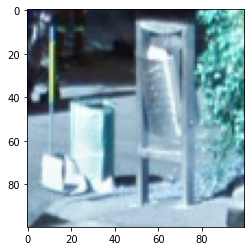

In [311]:
plt.imshow(X_train[1].reshape(100,100,3))

In [312]:
print(y_test.shape)
print(y_train.shape)

(659,)
(2636,)


In [313]:
x_train = X_train.reshape([-1, 100, 100, 3]) #AGREGAMOS -1 PARA LOS INDICES DE LAS IMAGENES
x_test = X_test.reshape([-1, 100, 100, 3])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255 #NORMALIZAMOS
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (2636, 100, 100, 3)
Number of images in x_train 2636
Number of images in x_test 659


In [314]:
datagen =DataAugmentation(x_train)


In [315]:
from keras.utils import np_utils
n_classes = 2
print("Shape antes del OneHotEncoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train,n_classes)
Y_test = np_utils.to_categorical(y_test,n_classes)
print("Shape después del OneHotEncoding: ", Y_train.shape)

Shape antes del OneHotEncoding:  (2636,)
Shape después del OneHotEncoding:  (2636, 2)


In [316]:
data_train = datagen.flow(x_train, Y_train, batch_size=64)


## CNN MODEL

In [317]:
model =  tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_uniform', activation='relu', input_shape=[100,100,3]))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 98, 98, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 49, 49, 64)        18496     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 49, 49, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 64)      

In [318]:
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt,  loss='categorical_crossentropy', metrics=['accuracy'])

In [319]:
history = model.fit(data_train, epochs=20, verbose=1,validation_data=(x_test,Y_test))

Epoch 1/20
42/42 [==============================] - 7s 154ms/step - loss: 0.6937 - accuracy: 0.5573 - val_loss: 0.6741 - val_accuracy: 0.6009
Epoch 2/20
42/42 [==============================] - 6s 150ms/step - loss: 0.6763 - accuracy: 0.5830 - val_loss: 0.6689 - val_accuracy: 0.5827
Epoch 3/20
42/42 [==============================] - 6s 148ms/step - loss: 0.6618 - accuracy: 0.6012 - val_loss: 0.6523 - val_accuracy: 0.6388
Epoch 4/20
42/42 [==============================] - 6s 147ms/step - loss: 0.6547 - accuracy: 0.6276 - val_loss: 0.6524 - val_accuracy: 0.6388
Epoch 5/20
42/42 [==============================] - 6s 148ms/step - loss: 0.6527 - accuracy: 0.6342 - val_loss: 0.6354 - val_accuracy: 0.6555
Epoch 6/20
42/42 [==============================] - 6s 147ms/step - loss: 0.6528 - accuracy: 0.6275 - val_loss: 0.6160 - val_accuracy: 0.6692
Epoch 7/20
42/42 [==============================] - 6s 147ms/step - loss: 0.6300 - accuracy: 0.6605 - val_loss: 0.6024 - val_accuracy: 0.6874
Epoch 

In [320]:
# Guardar el modelo
model.save('/content/drive/My Drive/PROYECTO IA2/Data/Models/CNN_v1.h5')

In [321]:
model= tf.keras.models.load_model('/content/drive/My Drive/PROYECTO IA2/Data/Models/CNN_v1.h5')

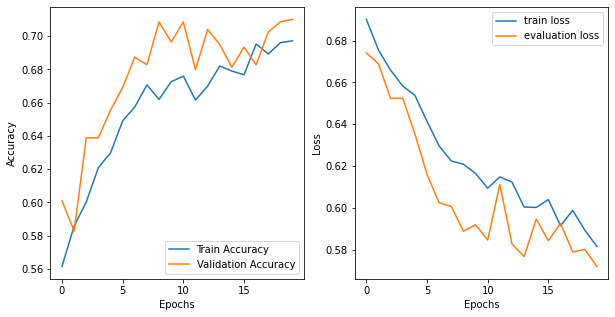

In [322]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

In [323]:
test_loss, test_acc = model.evaluate(x_test, Y_test, verbose=0)

print('Test accuracy:', test_acc)

Test accuracy: 0.7101669311523438


## TRANSFER LEARNING

### MobileNet V2

In [324]:
model_A =  tf.keras.applications.MobileNetV2(input_shape=x_train[0].shape, weights='imagenet', include_top=False)
model_A.trainable = False
model_A.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 50, 50, 32)   864         input_9[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 50, 50, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 50, 50, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [325]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
flatten_layer = tf.keras.layers.Flatten()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # To mobilenet cnns

In [326]:
model_B_on_A = tf.keras.Sequential([
  model_A,
  global_average_layer,
  prediction_layer
])

In [327]:
model_B_on_A.summary()
print("number of layers to train: ", len(model_B_on_A.trainable_variables))

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1280)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
number of layers to train:  2


In [328]:
learning_rate= 0.001
opt = tf.keras.optimizers.SGD(lr=learning_rate, momentum=0.9)
model_B_on_A.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

history = model_B_on_A.fit(data_train, epochs=20, validation_data=(x_test, Y_test))

Epoch 1/20
42/42 [==============================] - 9s 163ms/step - loss: 0.9845 - accuracy: 0.5393 - val_loss: 0.6769 - val_accuracy: 0.6829
Epoch 2/20
42/42 [==============================] - 6s 143ms/step - loss: 0.5851 - accuracy: 0.7125 - val_loss: 0.6004 - val_accuracy: 0.7086
Epoch 3/20
42/42 [==============================] - 6s 143ms/step - loss: 0.5904 - accuracy: 0.7207 - val_loss: 0.5875 - val_accuracy: 0.7147
Epoch 4/20
42/42 [==============================] - 6s 144ms/step - loss: 0.5349 - accuracy: 0.7356 - val_loss: 0.6790 - val_accuracy: 0.7011
Epoch 5/20
42/42 [==============================] - 6s 142ms/step - loss: 0.5177 - accuracy: 0.7371 - val_loss: 0.5999 - val_accuracy: 0.7223
Epoch 6/20
42/42 [==============================] - 6s 142ms/step - loss: 0.5143 - accuracy: 0.7509 - val_loss: 0.5875 - val_accuracy: 0.7041
Epoch 7/20
42/42 [==============================] - 6s 142ms/step - loss: 0.5017 - accuracy: 0.7630 - val_loss: 0.5751 - val_accuracy: 0.7117
Epoch 

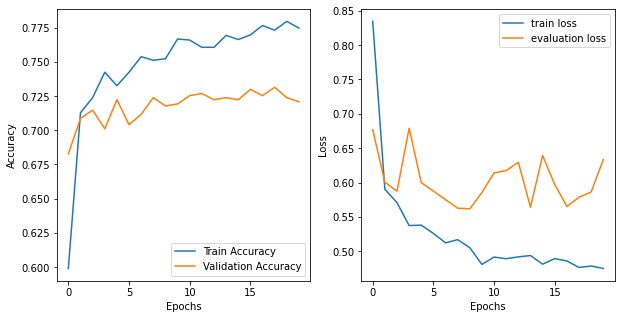

In [329]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

### MobileNet V2 with Fine Tunning

Descongelando y entrenando las primeras 100 capas

In [330]:
model_A.trainable = True
print("Total layers of Mobilenet: ", len(model_A.layers))
for layer in model_A.layers[:100]:
  layer.trainable =  False
print("Total layers of Mobilenet: ", len(model_A.layers))

Total layers of Mobilenet:  154
Total layers of Mobilenet:  154


In [331]:
model_B_on_A.summary()
len(model_B_on_A.trainable_variables)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1280)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 1,864,002
Non-trainable params: 396,544
_________________________________________________________________


56

In [332]:
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model_B_on_A.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

history = model_B_on_A.fit(data_train, epochs=20,verbose=1,validation_data=(x_test, Y_test))

Epoch 1/20
42/42 [==============================] - 10s 168ms/step - loss: 0.6059 - accuracy: 0.6828 - val_loss: 0.9539 - val_accuracy: 0.7071
Epoch 2/20
42/42 [==============================] - 6s 148ms/step - loss: 0.4783 - accuracy: 0.7793 - val_loss: 0.7626 - val_accuracy: 0.7344
Epoch 3/20
42/42 [==============================] - 6s 150ms/step - loss: 0.4210 - accuracy: 0.8020 - val_loss: 0.8164 - val_accuracy: 0.7360
Epoch 4/20
42/42 [==============================] - 6s 150ms/step - loss: 0.3593 - accuracy: 0.8358 - val_loss: 0.6738 - val_accuracy: 0.7648
Epoch 5/20
42/42 [==============================] - 6s 149ms/step - loss: 0.3407 - accuracy: 0.8517 - val_loss: 0.8637 - val_accuracy: 0.7405
Epoch 6/20
42/42 [==============================] - 6s 150ms/step - loss: 0.3352 - accuracy: 0.8460 - val_loss: 0.6895 - val_accuracy: 0.7769
Epoch 7/20
42/42 [==============================] - 6s 148ms/step - loss: 0.3031 - accuracy: 0.8695 - val_loss: 0.5757 - val_accuracy: 0.7785
Epoch

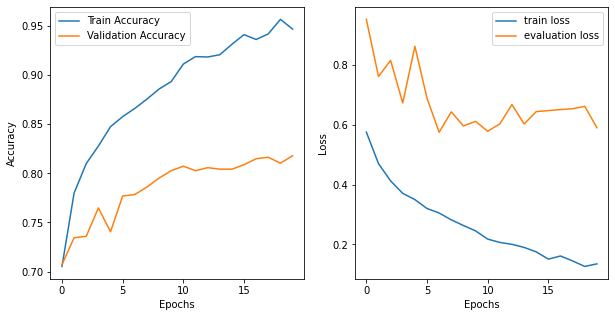

In [333]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

### Xception

In [334]:
model_X =  tf.keras.applications.Xception(input_shape=x_train[0].shape, weights='imagenet', include_top=False)
model_X.trainable = False
model_X.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_10[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [335]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
flatten_layer = tf.keras.layers.Flatten()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # To mobilenet cnns

In [336]:
model_B_on_X = tf.keras.Sequential([
  model_X,
  global_average_layer,
  prediction_layer
])

In [337]:
model_B_on_X.summary()
print("number of layers to train: ", len(model_B_on_A.trainable_variables))

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
_________________________________________________________________
number of layers to train:  56


In [338]:
learning_rate= 0.001
opt = tf.keras.optimizers.SGD(lr=learning_rate, momentum=0.9)
model_B_on_X.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

history = model_B_on_X.fit(data_train, epochs=20, validation_data=(x_test, Y_test))

Epoch 1/20
42/42 [==============================] - 10s 178ms/step - loss: 0.7073 - accuracy: 0.5495 - val_loss: 0.6186 - val_accuracy: 0.6737
Epoch 2/20
42/42 [==============================] - 7s 163ms/step - loss: 0.6176 - accuracy: 0.6765 - val_loss: 0.5886 - val_accuracy: 0.6935
Epoch 3/20
42/42 [==============================] - 7s 166ms/step - loss: 0.5878 - accuracy: 0.7020 - val_loss: 0.5774 - val_accuracy: 0.7117
Epoch 4/20
42/42 [==============================] - 7s 160ms/step - loss: 0.5763 - accuracy: 0.7144 - val_loss: 0.5690 - val_accuracy: 0.7208
Epoch 5/20
42/42 [==============================] - 7s 159ms/step - loss: 0.5463 - accuracy: 0.7254 - val_loss: 0.5676 - val_accuracy: 0.7223
Epoch 6/20
42/42 [==============================] - 7s 159ms/step - loss: 0.5579 - accuracy: 0.7061 - val_loss: 0.5571 - val_accuracy: 0.7329
Epoch 7/20
42/42 [==============================] - 7s 165ms/step - loss: 0.5594 - accuracy: 0.7042 - val_loss: 0.5506 - val_accuracy: 0.7344
Epoch

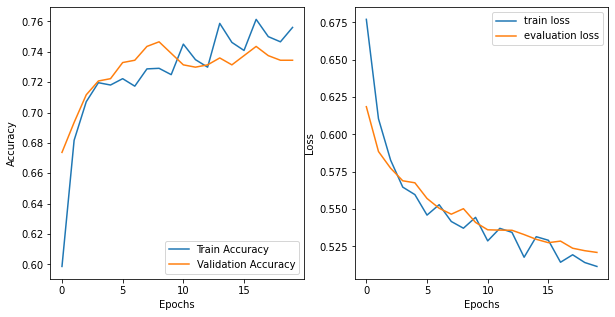

In [339]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

### Xception with Fine Tunning

Descongelando y entrenando las primeras 100 capas

In [340]:
model_X.trainable = True
print("Total layers of Mobilenet: ", len(model_X.layers))
for layer in model_X.layers[:100]:
  layer.trainable =  False
print("Total layers of Mobilenet: ", len(model_X.layers))

Total layers of Mobilenet:  132
Total layers of Mobilenet:  132


In [341]:
model_B_on_X.summary()
len(model_B_on_X.trainable_variables)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 9,482,442
Non-trainable params: 11,383,136
_________________________________________________________________


41

In [342]:
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model_B_on_X.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_B_on_X.fit(data_train, epochs=20,verbose=1,validation_data=(x_test, Y_test))

Epoch 1/20
42/42 [==============================] - 11s 194ms/step - loss: 0.6211 - accuracy: 0.6961 - val_loss: 0.5214 - val_accuracy: 0.7572
Epoch 2/20
42/42 [==============================] - 8s 180ms/step - loss: 0.5955 - accuracy: 0.7120 - val_loss: 0.5163 - val_accuracy: 0.7709
Epoch 3/20
42/42 [==============================] - 8s 179ms/step - loss: 0.5813 - accuracy: 0.7086 - val_loss: 0.5114 - val_accuracy: 0.7678
Epoch 4/20
42/42 [==============================] - 7s 174ms/step - loss: 0.5491 - accuracy: 0.7538 - val_loss: 0.5086 - val_accuracy: 0.7542
Epoch 5/20
42/42 [==============================] - 7s 177ms/step - loss: 0.5461 - accuracy: 0.7469 - val_loss: 0.5055 - val_accuracy: 0.7663
Epoch 6/20
42/42 [==============================] - 8s 183ms/step - loss: 0.5361 - accuracy: 0.7392 - val_loss: 0.5030 - val_accuracy: 0.7587
Epoch 7/20
42/42 [==============================] - 8s 179ms/step - loss: 0.5254 - accuracy: 0.7566 - val_loss: 0.4966 - val_accuracy: 0.7663
Epoch

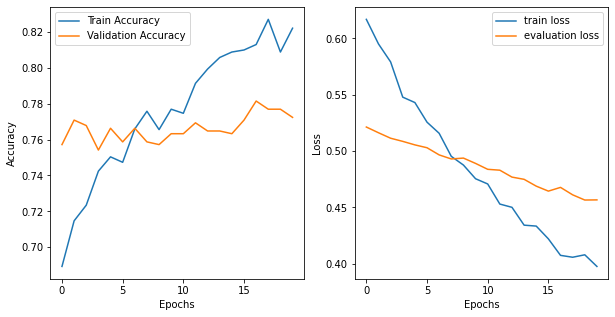

In [343]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

## PRUEBAS Y RESULTADOS

### Confusion Matrix

In [344]:

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\ntest accuracy={:0.4f}'.format(accuracy, misclass))
    plt.show()

#### Model CNN

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(659,)


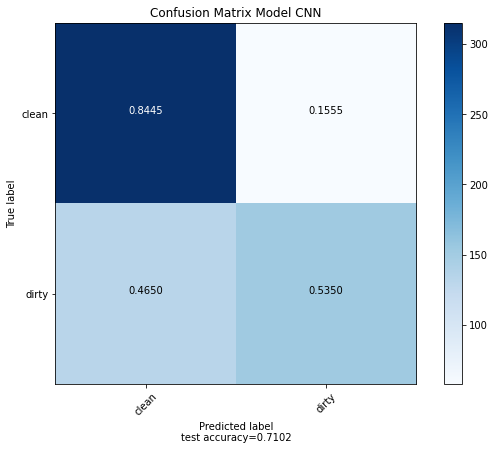

In [345]:
from sklearn.metrics import confusion_matrix

predictions = model.predict_classes(x_test)
print(predictions.shape)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, target_names=['clean', 'dirty'], title = "Confusion Matrix Model CNN")

#### Model MobileNetV2

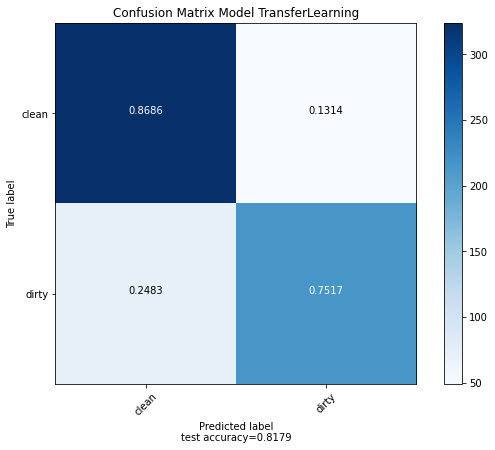

In [346]:
from sklearn.metrics import confusion_matrix


predictions = model_B_on_A.predict(x_test)

pclasses = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, pclasses)
plot_confusion_matrix(cm, target_names=['clean', 'dirty'], title = "Confusion Matrix Model TransferLearning")

#### Model Xception

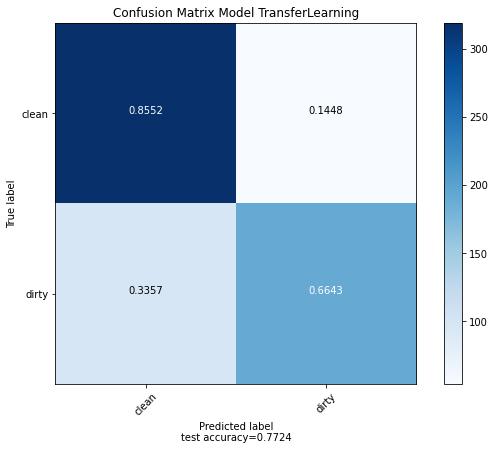

In [347]:
predictions = model_B_on_X.predict(x_test)

pclasses = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, pclasses)
plot_confusion_matrix(cm, target_names=['clean', 'dirty'], title = "Confusion Matrix Model TransferLearning")

### Pruebas con new dataset

In [358]:
Xnew =[]
ynew =[]
resize_value =100
path_classes = 'Data/colombianData/'

classes_names = os.listdir(path_classes)
classes_names.sort()
classes_names = classes_names[0:]



list_imgs = []
dic_imgs= {}
for i, name_class in enumerate(classes_names):
    list_imgs = list_imgs +[name_class+ "/"+ s for s in (os.listdir(path_classes + classes_names[i]))] 
    dic_imgs[classes_names[i]]=np.array(os.listdir(path_classes + classes_names[i])) #diccionario que tiene como keys: (clean, dirty) y como values las respectivas imagenes correspondientes a las keys
array_imgs = np.array(list_imgs) #array con los nombres de las imagenes con formato 'clase/nombreimagen'

#etiquetar las clases 
for i, classes in enumerate(['clean', 'dirty']):
    print((i), "clase: ", classes, " y_value:",  (i), " total: ", len(dic_imgs[classes]))
    
    for im_name in dic_imgs[classes]:
        path_image = path_classes+classes+'/'+im_name        
        img = cv2.resize(cv2.imread(path_image,3), (100, 100))
        Xnew.append(img)
        #print len(X)
        ynew.append(i)
Xnew = np.r_[Xnew]
ynew = np.r_[ynew]

0 clase:  clean  y_value: 0  total:  214
1 clase:  dirty  y_value: 1  total:  77


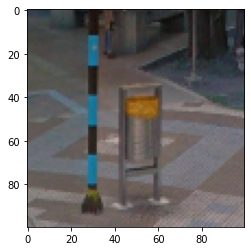

In [359]:
plt.imshow(Xnew[4])

In [360]:
ynew[3]

0

#### Model CNN

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(291,)


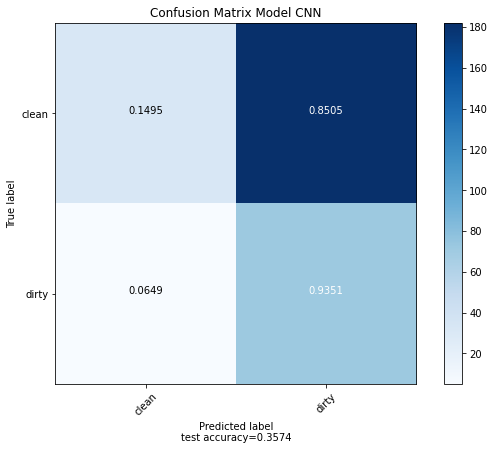

In [361]:
from sklearn.metrics import confusion_matrix

predictions = model.predict_classes(Xnew)
print(predictions.shape)
cm = confusion_matrix(ynew, predictions)
plot_confusion_matrix(cm, target_names=['clean', 'dirty'], title = "Confusion Matrix Model CNN")

#### Model MobileNetV2

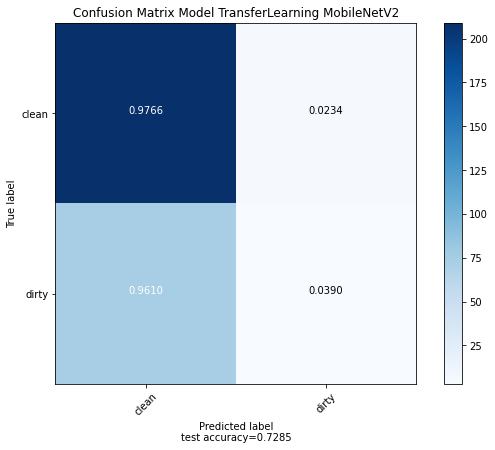

In [362]:
from sklearn.metrics import confusion_matrix


predictions = model_B_on_A.predict(Xnew)

pclasses = np.argmax(predictions, axis=1)

cm = confusion_matrix(ynew, pclasses)
plot_confusion_matrix(cm, target_names=['clean', 'dirty'], title = "Confusion Matrix Model TransferLearning MobileNetV2")

#### Model Xception

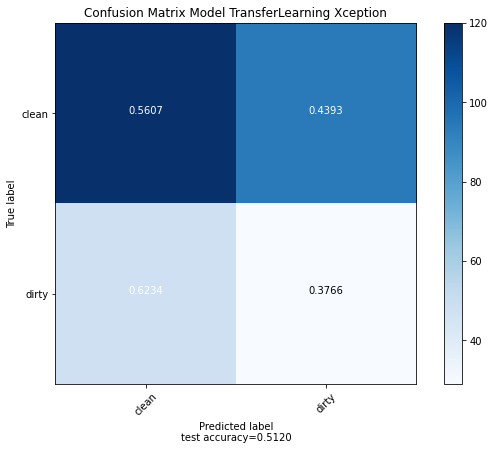

In [363]:
predictions = model_B_on_X.predict(Xnew)

pclasses = np.argmax(predictions, axis=1)

cm = confusion_matrix(ynew, pclasses)
plot_confusion_matrix(cm, target_names=['clean', 'dirty'], title = "Confusion Matrix Model TransferLearning Xception")